<a href="https://colab.research.google.com/github/Tclack88/Renewable-Energy/blob/master/rooftop_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# contents of requirements.txt
"""PyYAML == 5.3.1
albumentations == 0.5.0
numpy == 1.19.2
opencv_python_headless == 4.4.0.44
py_oneliner == 0.0.1
scikit_learn == 0.23.2
torch
torchvision
tqdm == 4.51.0"""

PyYAML == 5.3.1
albumentations == 0.5.0
numpy == 1.19.2
opencv_python_headless == 4.4.0.44
py_oneliner == 0.0.1
scikit_learn == 0.23.2
torch
torchvision
tqdm == 4.51.0


# installation and model training
https://github.com/fuzailpalnak/building-footprint-segmentation

In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 8.6 MB/s 
     |████████████████████████████████| 70 kB 7.8 MB/s 
     |████████████████████████████████| 14.5 MB 57.3 MB/s 
     |████████████████████████████████| 36.7 MB 1.3 MB/s 
     |████████████████████████████████| 6.8 MB 46.6 MB/s 
     |████████████████████████████████| 70 kB 9.7 MB/s 
     |████████████████████████████████| 948 kB 50.3 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=ff0d5b0e24fcc6320b1c73dbd242fc65f77b7e15cc9bd5018a2d69ecc010fdfd
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
  Created wheel for py-oneliner: filename=py_oneliner-0.0.1-py3-none-any.whl size=3695 sha256=81026d4bbf77d833b28f5751e0a93398f23d2cd581aec1722819db140be31817
  Stored in directory: /root/.cache/pip/wheels/60/1d/9c/e41b84d872c303b2

In [1]:
!git clone https://github.com/fuzailpalnak/building-footprint-segmentation.git

Cloning into 'building-footprint-segmentation'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 390 (delta 31), reused 74 (delta 30), pack-reused 307
Receiving objects: 100% (390/390), 100.34 KiB | 11.15 MiB/s, done.
Resolving deltas: 100% (213/213), done.


In [2]:
!mv building-footprint-segmentation/requirements.txt .
!ls

building-footprint-segmentation  requirements.txt  sample_data


In [4]:
!pip install building_footprint_segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import sys
import json
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from building_footprint_segmentation.segmentation import init_segmentation, read_trainer_config
from building_footprint_segmentation.helpers.callbacks import CallbackList, load_callback
from building_footprint_segmentation.trainer import Trainer

In [6]:
segmentation = init_segmentation("binary")

In [7]:
augmenters = {'transform': {'__class_fullname__': 'albumentations.core.composition.Compose', 'bbox_params': None, 'keypoint_params': None, 'p': 1, 'transforms': [{'__class_fullname__': 'albumentations.augmentations.transforms.HorizontalFlip', 'always_apply': False, 'p': 0.5}]}}
print(json.dumps(augmenters, indent=2))


{
  "transform": {
    "__class_fullname__": "albumentations.core.composition.Compose",
    "bbox_params": null,
    "keypoint_params": null,
    "p": 1,
    "transforms": [
      {
        "__class_fullname__": "albumentations.augmentations.transforms.HorizontalFlip",
        "always_apply": false,
        "p": 0.5
      }
    ]
  }
}


In [9]:
#[ReFineNetLite, MFRN, ReFineNet] # "AlBuNet" doesn't work, change
model_name = "ReFineNet"
root_folder = r'./data'
out_folder = r'./out_data'
# for data you will have to download and split the data the library does not handle data 
# splits the library expects the data be present in the following format
# ├── train
# │   ├── images          # images to train
# │   ├── labels          # corresponding ground truth
# |
# ├── val
# │   ├── images          # images to validate
# │   ├── labels          # corresponding ground truth
# │
# ├── test
# │   ├── images 
# and for logging it could be any directory and if the directory does not exists then the library creates one.

model = segmentation.load_model(name=model_name)
criterion = segmentation.load_criterion(name="BinaryCrossEntropy")
loader = segmentation.load_loader(
    root_folder=root_folder,
    image_normalization="divide_by_255",
    label_normalization="binary_label",
    augmenters=augmenters,
    batch_size=2,
)
metrics = segmentation.load_metrics(
    data_metrics=["accuracy", "precision", "f1", "recall", "iou"]
)

optimizer = segmentation.load_optimizer(model, name="Adam")

callbacks = CallbackList([BinaryTestCallback(out_folder)])

# Ouptut from all the callbacks caller will be stored at the path specified in log_dir
for caller in  ["TrainChkCallback", "TimeCallback", "TensorBoardCallback", "TrainStateCallback", "BinaryTestCallback"]:
    callbacks.append(load_callback(out_folder, caller))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


ValueError: ignored

In [7]:
trainer = Trainer(
    model=model,
    criterion=criterion,
    loader=loader,
    metrics=metrics,
    callbacks=callbacks,
    optimizer=optimizer,
    scheduler=None,
)

# USE MODEL FROM PRETRAINED WEIGHTS

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [38]:
import cv2
from building_footprint_segmentation.seg.binary.models import ReFineNet
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor,
    add_extra_dimension,
    convert_tensor_to_numpy,
    load_parallel_model
)
from building_footprint_segmentation.utils.operations import handle_image_size
from torch.utils import model_zoo

MAX_SIZE = 384
MODEL_URL = "https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/alpha/refine.zip"


def get_model():
    refine_net = ReFineNet()
    state_dict = model_zoo.load_url(MODEL_URL, progress=True, map_location="cpu")
    refine_net.load_state_dict(state_dict)
    return refine_net


def extract(original_image, model):

    original_height, original_width = original_image.shape[:2]

    if (original_height, original_width) != (MAX_SIZE, MAX_SIZE):
        original_image = handle_image_size(original_image, (MAX_SIZE, MAX_SIZE))

    # Apply Normalization
    normalized_image = min_max_image_net(img=original_image)

    tensor_image = add_extra_dimension(to_input_image_tensor(normalized_image))

    with torch.no_grad():
        # Perform prediction
        prediction = model(tensor_image)
        prediction = prediction.sigmoid()

    prediction_binary = convert_tensor_to_numpy(prediction[0]).reshape(
        (MAX_SIZE, MAX_SIZE)
    )

    prediction_3_channels = cv2.cvtColor(prediction_binary, cv2.COLOR_GRAY2RGB)

    dst = cv2.addWeighted(
        original_image,
        1,
        (prediction_3_channels * (0, 255, 0)).astype(np.uint8),
        0.4,
        0,
    )
    return prediction_binary, prediction_3_channels, dst


def run(image_path):
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    model = get_model()
    # PARALLELIZE the model if gpu available
    # model = load_parallel_model(model)
    
    prediction_binary, prediction_3_channels, dst = extract(original_image, model)
    return prediction_binary, prediction_3_channels, dst



In [12]:
!wget "https://www.nearmap.com/content/dam/nearmap/blog-imagery/nearmap-blog-au/roof-pitch-and-area/aerial-roofing-colorful-rothwell-qld-2018-07-26.png?format=pjpg&auto=webp&width=3840"

--2022-07-03 08:53:02--  https://www.nearmap.com/content/dam/nearmap/blog-imagery/nearmap-blog-au/roof-pitch-and-area/aerial-roofing-colorful-rothwell-qld-2018-07-26.png?format=pjpg&auto=webp&width=3840
Resolving www.nearmap.com (www.nearmap.com)... 151.101.2.224, 151.101.66.224, 151.101.130.224, ...
Connecting to www.nearmap.com (www.nearmap.com)|151.101.2.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448384 (438K) [image/jpeg]
Saving to: ‘aerial-roofing-colorful-rothwell-qld-2018-07-26.png?format=pjpg&auto=webp&width=3840’

aerial-roofing-colo 100%[===================>] 437.88K  --.-KB/s    in 0.02s   

2022-07-03 08:53:03 (18.9 MB/s) - ‘aerial-roofing-colorful-rothwell-qld-2018-07-26.png?format=pjpg&auto=webp&width=3840’ saved [448384/448384]



In [45]:
# Random image from the internet
# image_path = "small_rooftop_sample.png" # this was smaller than 384x384 and failed TODO find out why (though probably not a problem)
image_path = "exact_rooftop_sample.png"
prediction_binary, prediction_3_channels, dst = run(image_path)

/usr/local/lib/python3.7/dist-packages/torch/hub.py:518: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


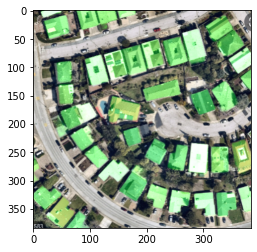

In [50]:
# from PIL import Image
plt.imshow(dst);